In [8]:
pip install moexalgo

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Fedor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [44]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128Note: you may need to restart the kernel to use updated packages.



ERROR: Could not find a version that satisfies the requirement torchvision (from versions: none)
ERROR: No matching distribution found for torchvision
You should consider upgrading via the 'c:\Users\Fedor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [26]:
from moexalgo import Ticker
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
imoex = Ticker('IMOEX') #Capitalisation of top 50 russian companies
moexeu = Ticker('MOEXEU') #Electroenergy
mscxm = Ticker('MCXSM') #Medium and small level of capitalisation (companies)

#historical data
hist_data_imoex = imoex.candles(start='2015-01-01', end='2024-12-31', period='1d')
hist_data_moexeu = moexeu.candles(start='2015-01-01', end='2024-12-31', period='1d')
hist_data_mscxm = mscxm.candles(start='2015-01-01', end='2024-12-31', period='1d')

df_imoex = pd.DataFrame(hist_data_imoex)
df_moexeu = pd.DataFrame(hist_data_moexeu)
df_mscxm = pd.DataFrame(hist_data_mscxm)

print(df_imoex.head())
print(df_moexeu.head())
print(df_mscxm.head())

      open    close     high      low         value  volume      begin  \
0  1394.66  1435.66  1438.91  1390.53  1.532069e+10     0.0 2015-01-05   
1  1435.39  1480.73  1481.35  1430.47  2.126881e+10     0.0 2015-01-06   
2  1482.12  1547.39  1564.87  1481.93  3.550506e+10     0.0 2015-01-08   
3  1547.61  1515.37  1557.96  1496.17  2.722306e+10     0.0 2015-01-09   
4  1515.23  1513.22  1534.74  1503.49  2.341906e+10     0.0 2015-01-12   

                  end  
0 2015-01-05 23:59:59  
1 2015-01-06 23:59:59  
2 2015-01-08 23:59:59  
3 2015-01-09 23:59:59  
4 2015-01-12 23:59:59  
     open   close    high     low        value  volume      begin  \
0  795.66  806.48  806.61  789.00  265095005.0     0.0 2015-01-05   
1  806.65  812.13  814.71  802.86  289490613.0     0.0 2015-01-06   
2  812.48  828.76  829.53  812.48  433346658.0     0.0 2015-01-08   
3  828.91  819.23  832.28  811.41  362992620.0     0.0 2015-01-09   
4  818.19  810.25  821.27  807.25  401548116.0     0.0 2015-01-12 

**DLWR**

In [18]:
def locally_weighted_regression(x, y, x_new, frac=0.2, degree=1):
    weights = np.exp(-(x - x_new)**2 / (2 * (frac * len(x))**2))
    W = np.diag(weights)
    X = np.vander(x - x_new, degree + 1)
    theta = linalg.pinv(X.T @ W @ X) @ X.T @ W @ y
    return theta[1]

def dynamic_lwr(data, window=10, frac=0.2):
    n = len(data)
    trend = np.zeros(n)
    for i in range(n):
        start = max(0, i - window + 1)
        x = np.arange(start, i + 1)
        y = data[start:i + 1]
        trend[i] = locally_weighted_regression(x, y, i, frac)
    return trend

def dlwr_trend_separation(data, separations=3, window=10, frac=0.2):
    trends = []
    residuals = data.copy()
    for _ in range(separations):
        trend = dynamic_lwr(residuals, window, frac)
        trends.append(trend)
        residuals = residuals - trend
    return trends, residuals

In [19]:
window_size = 10
frac_param = 0.2
separations = 3

dates_imoex = df_imoex['begin'].values
target_imoex = df_imoex['close'].values

dates_moexeu = df_moexeu['begin'].values
target_moexeu = df_moexeu['close'].values

dates_mscxm = df_mscxm['begin'].values
target_mscxm = df_mscxm['close'].values

trends_imoex, noise_imoex = dlwr_trend_separation(target_imoex, window=window_size, frac=frac_param, separations=separations)
trends_moexeu, noise_moexeu = dlwr_trend_separation(target_moexeu, window=window_size, frac=frac_param, separations=separations)
trends_mscxm, noise_mscxm = dlwr_trend_separation(target_mscxm, window=window_size, frac=frac_param, separations=separations)

print(target_imoex[0])
print(trends_imoex[0][0])
#Means
print("Means:")
print(f"Mean f0: {np.mean(trends_imoex[0]):.4f}")
print(f"Mean f1: {np.mean(trends_imoex[1]):.4f}")
print(f"Mean f2: {np.mean(trends_imoex[2]):.4f}")
print(f"Mean noise: {np.mean(noise_imoex):.4f}")

#Recunstruction to test whether its close
reconstructed = trends_imoex[0] + trends_imoex[1] + trends_imoex[2] + noise_imoex
reconstruction_error = np.max(np.abs(reconstructed - target_imoex))
print(f"\nMax error reconstruction: {reconstruction_error:.2e}")

1435.66
1435.66
Means:
Mean f0: 2559.1123
Mean f1: 0.0080
Mean f2: 0.0041
Mean noise: 0.0005

Max error reconstruction: 9.09e-13


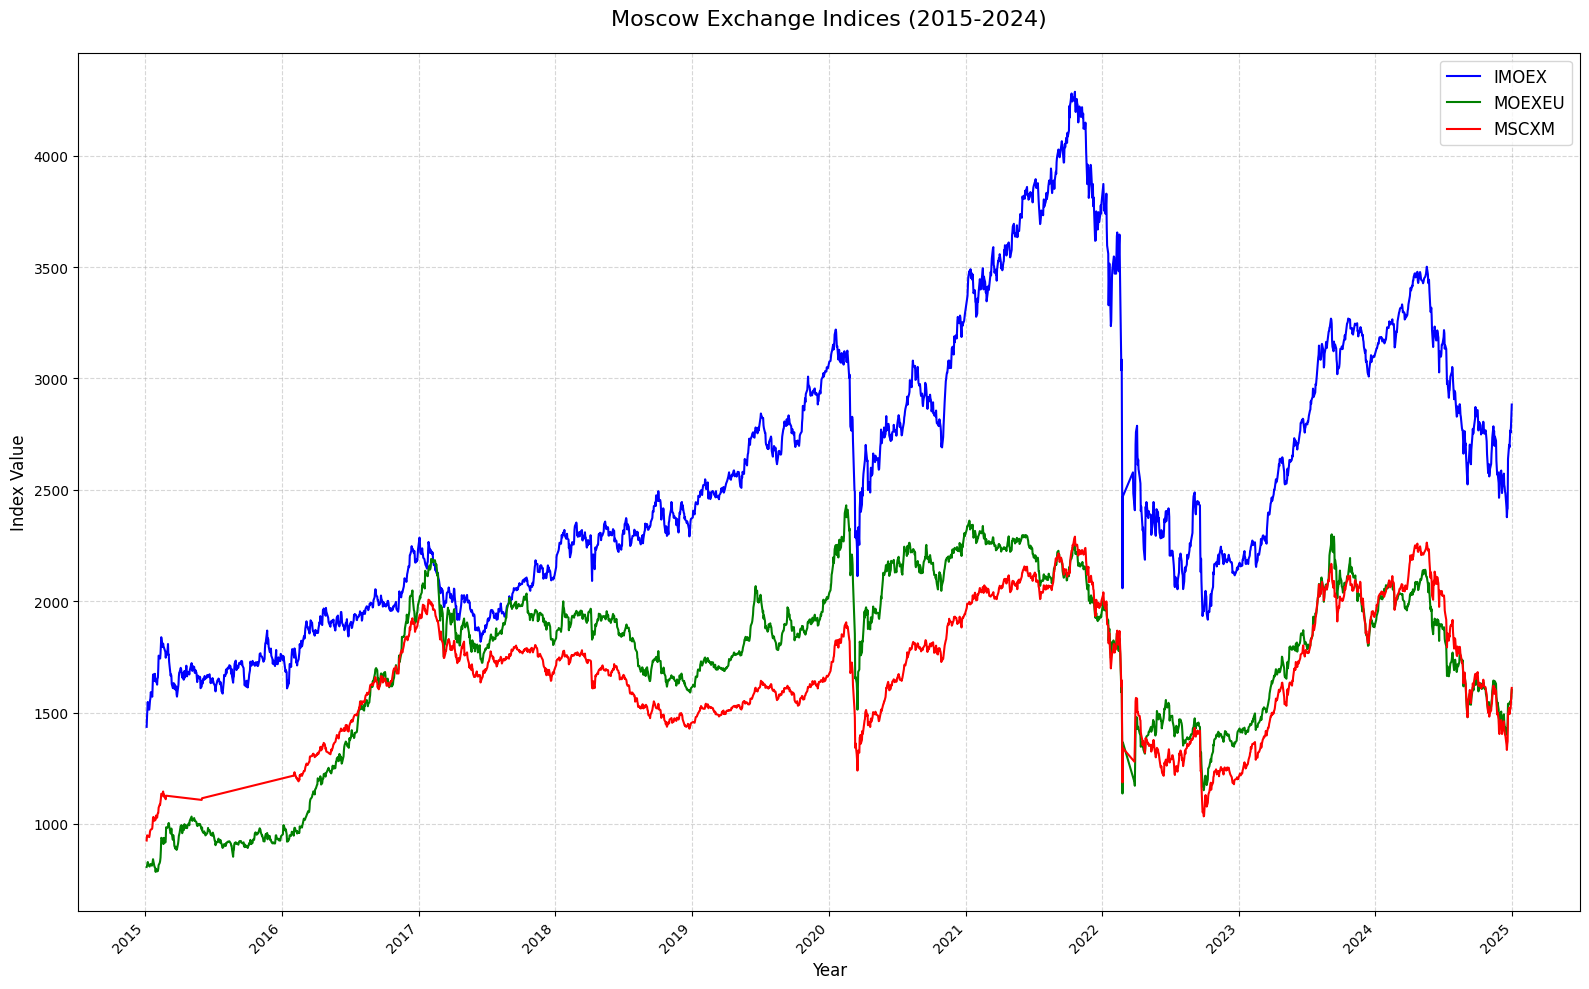

In [59]:
plt.figure(figsize=(16, 10))


plt.plot(dates_imoex, target_imoex, label="IMOEX", color="blue", linewidth=1.5)
plt.plot(dates_moexeu, target_moexeu, label="MOEXEU", color="green", linewidth=1.5)
plt.plot(dates_mscxm, target_mscxm, label="MSCXM", color="red", linewidth=1.5)

plt.title("Moscow Exchange Indices (2015-2024)", fontsize=16, pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Index Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)

years = range(2015, 2026)
plt.xticks(
    [pd.Timestamp(f"{year}-01-01") for year in years],
    [str(year) for year in years],
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.savefig("moex_indices_plot.png", dpi=300, bbox_inches="tight")
plt.show()

**Visualisation IMOEX**

In [21]:
f0_last_imoex = trends_imoex[0][-60:]
f1_last_imoex = trends_imoex[1][-60:]
f2_last_imoex = trends_imoex[2][-60:]
d0_last_imoex = (target_imoex - trends_imoex[0])[-60:]
d1_last_imoex = (target_imoex - trends_imoex[0] - trends_imoex[1])[-60:]
d2_last_imoex = noise_imoex[-60:]
np.mean(trends_imoex)

np.float64(853.0414565899623)

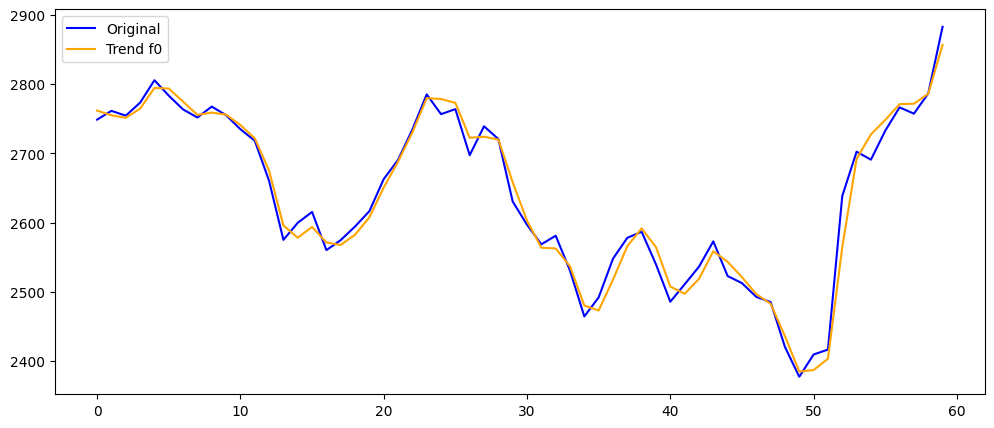

In [73]:
plt.figure(figsize=(12, 5))
plt.plot(target_imoex[-60:], label='Original', color='blue')
plt.plot(f0_last_imoex, label='Trend f0', color='orange')
plt.legend()
plt.show()

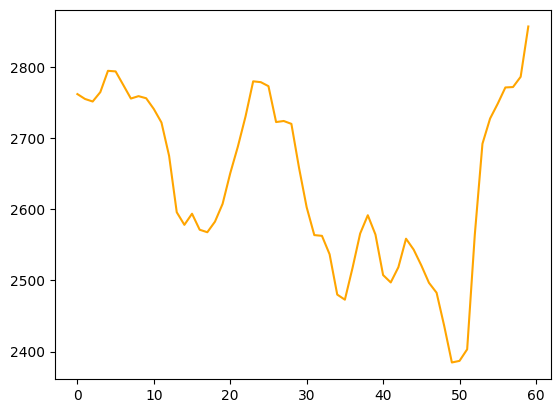

In [62]:
plt.plot(f0_last_imoex, color='orange', label='f0')

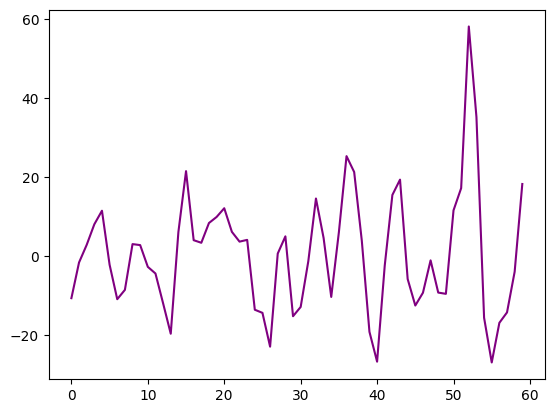

In [63]:
plt.plot(f1_last_imoex, color='purple', label='f1')

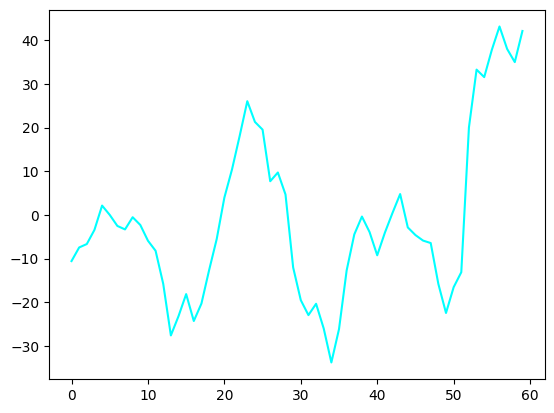

In [ ]:
plt.plot(f2_last_imoex, color='cyan', label='f2')

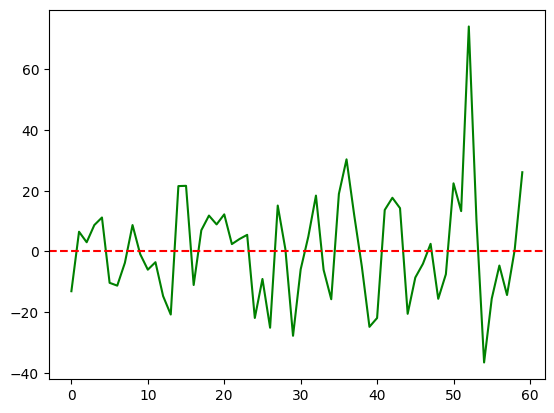

In [64]:
plt.plot(d0_last_imoex, color='green', label='d0')
plt.axhline(0, color='red', linestyle='--')

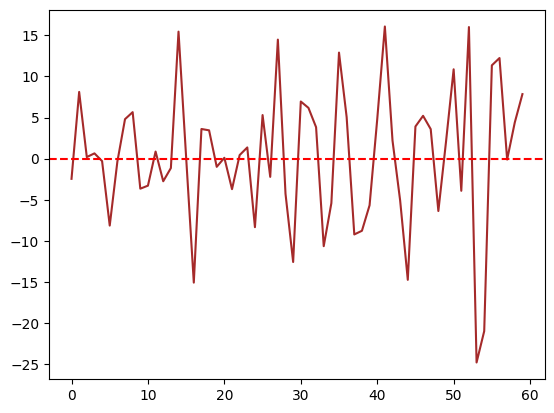

In [65]:
plt.plot(d1_last_imoex, color='brown', label='d1')
plt.axhline(0, color='red', linestyle='--')

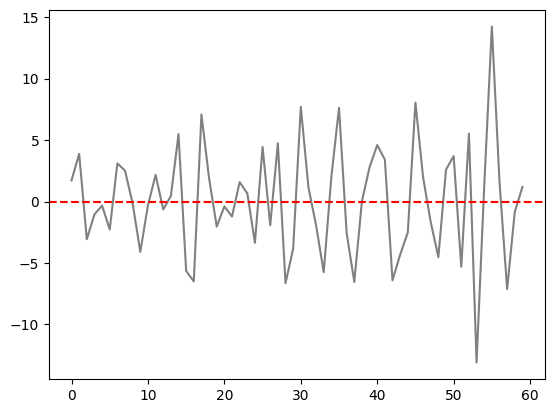

In [66]:
plt.plot(d2_last_imoex, color='gray', label='d2')
plt.axhline(0, color='red', linestyle='--')

**Visualisation MOEXEU**

In [20]:
f0_last_moexeu = trends_moexeu[0][-60:]
f1_last_moexeu = trends_moexeu[1][-60:]
f2_last_moexeu = trends_moexeu[2][-60:]
d0_last_moexeu = (target_moexeu - trends_moexeu[0])[-60:]
d1_last_moexeu = (target_moexeu - trends_moexeu[0] - trends_moexeu[1])[-60:]
d2_last_moexeu = noise_moexeu[-60:]
np.mean(trends_moexeu)

np.float64(578.3306505213262)

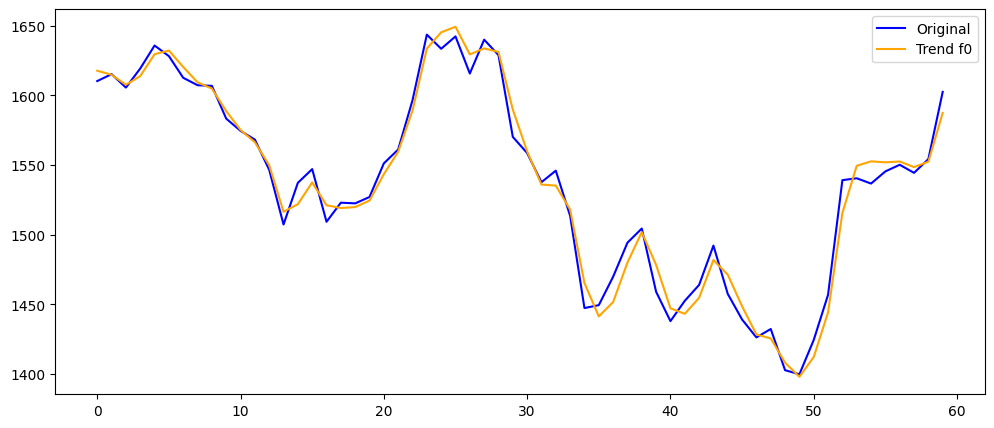

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(target_moexeu[-60:], label='Original', color='blue')
plt.plot(f0_last_moexeu, label='Trend f0', color='orange')
plt.legend()
plt.show()

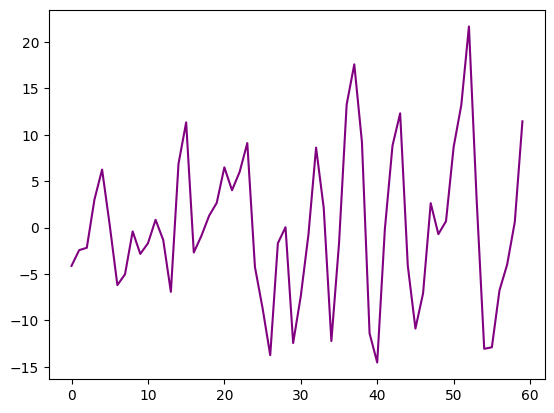

In [17]:
plt.plot(f1_last_moexeu, color='purple', label='f1')

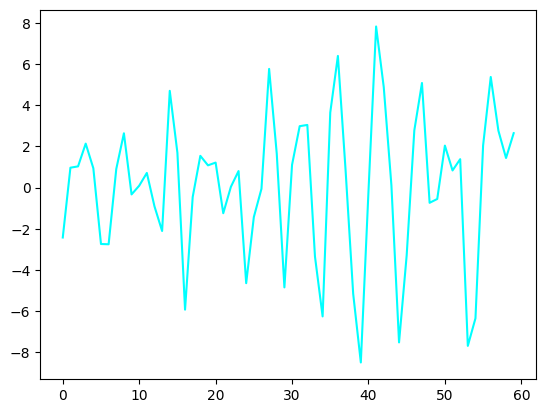

In [12]:
plt.plot(f2_last_moexeu, color='cyan', label='f2')

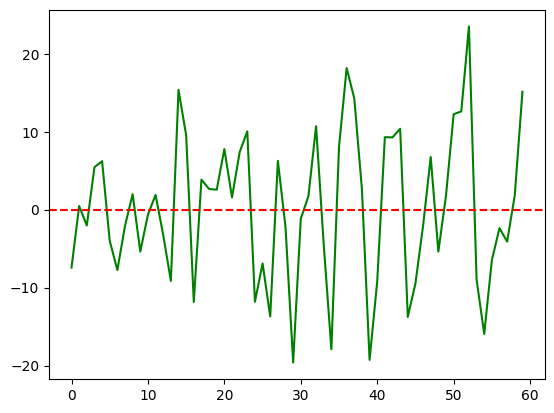

In [13]:
plt.plot(d0_last_moexeu, color='green', label='d0')
plt.axhline(0, color='red', linestyle='--')

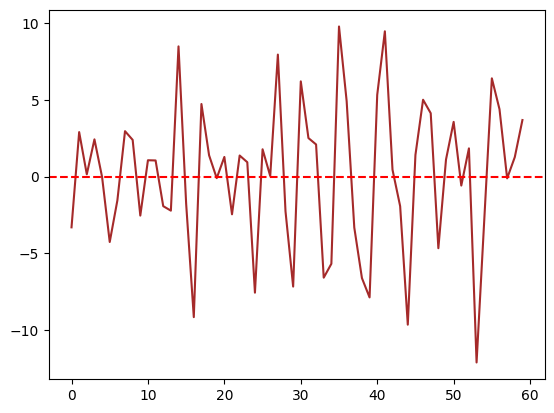

In [14]:
plt.plot(d1_last_moexeu, color='brown', label='d1')
plt.axhline(0, color='red', linestyle='--')

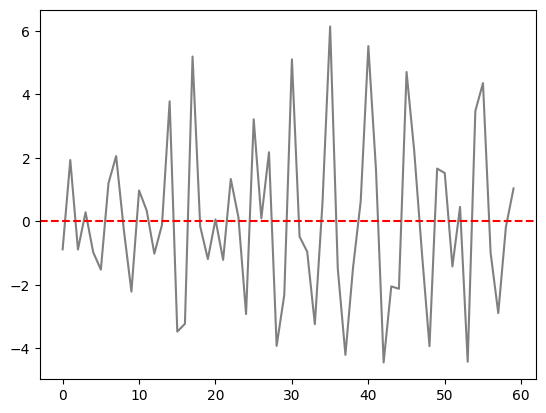

In [15]:
plt.plot(d2_last_moexeu, color='gray', label='d2')
plt.axhline(0, color='red', linestyle='--')

**Visualisasion MSCXM**

In [22]:
f0_last_mscxm = trends_mscxm[0][-60:]
f1_last_mscxm = trends_mscxm[1][-60:]
f2_last_mscxm = trends_mscxm[2][-60:]
d0_last_mscxm = (target_mscxm - trends_mscxm[0])[-60:]
d1_last_mscxm = (target_mscxm - trends_mscxm[0] - trends_mscxm[1])[-60:]
d2_last_mscxm = noise_mscxm[-60:]
np.mean(trends_mscxm)

np.float64(562.8791958610178)

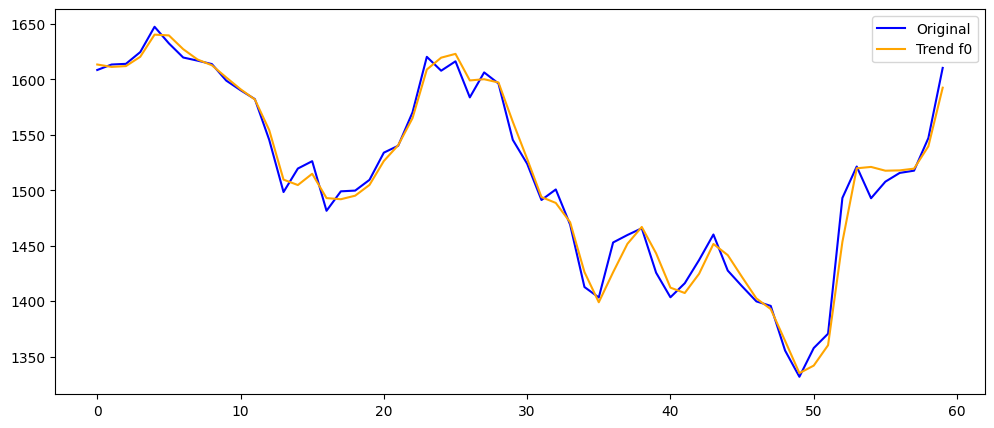

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(target_mscxm[-60:], label='Original', color='blue')
plt.plot(f0_last_mscxm, label='Trend f0', color='orange')
plt.legend()
plt.show()

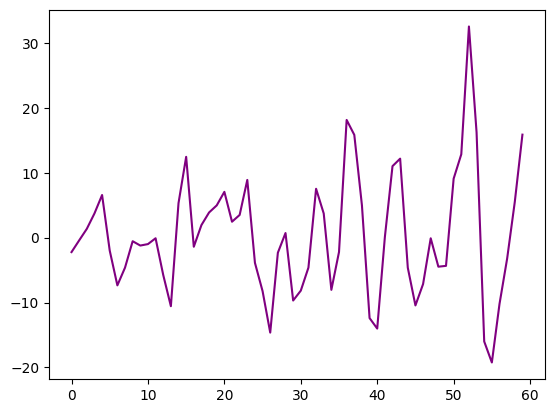

In [20]:
plt.plot(f1_last_mscxm, color='purple', label='f1')

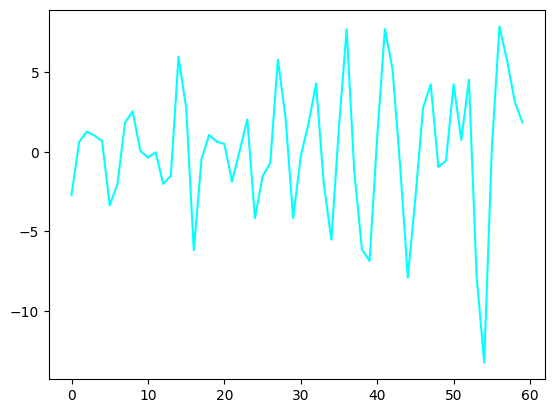

In [21]:
plt.plot(f2_last_mscxm, color='cyan', label='f2')

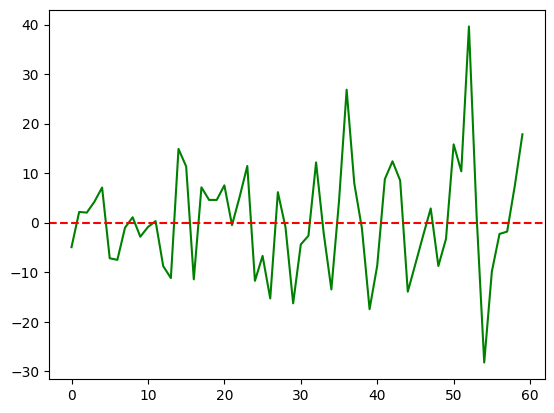

In [22]:
plt.plot(d0_last_mscxm, color='green', label='d0')
plt.axhline(0, color='red', linestyle='--')

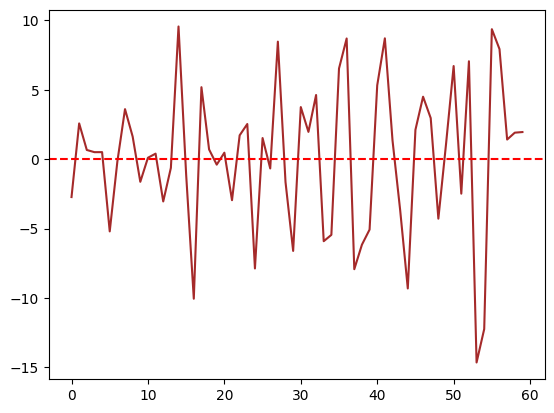

In [23]:
plt.plot(d1_last_mscxm, color='brown', label='d1')
plt.axhline(0, color='red', linestyle='--')

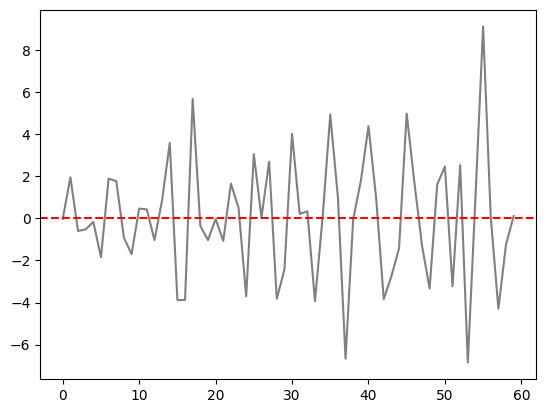

In [24]:
plt.plot(d2_last_mscxm, color='gray', label='d2')
plt.axhline(0, color='red', linestyle='--')

**Checking autocorellation of noise**

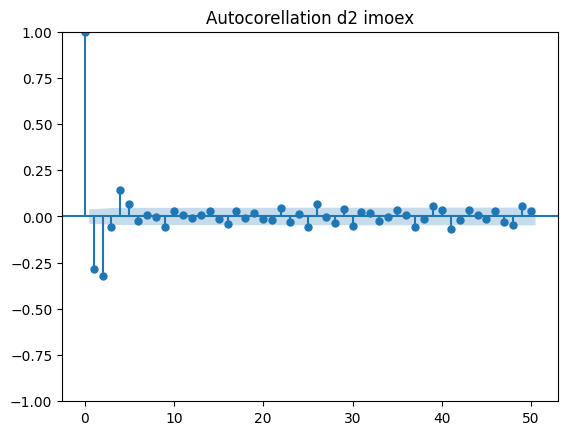

In [26]:
plot_acf(target_imoex - trends_imoex[0] - trends_imoex[1] - trends_imoex[2], lags=50)
plt.title("Autocorellation d2 imoex")
plt.show()

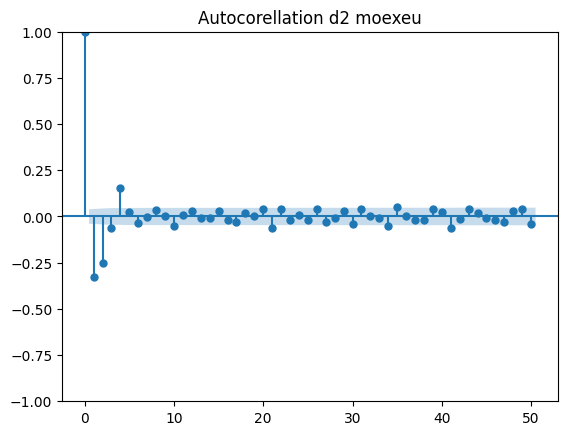

In [28]:
plot_acf(target_moexeu - trends_moexeu[0] - trends_moexeu[1] - trends_moexeu[2], lags=50)
plt.title("Autocorellation d2 moexeu")
plt.show()

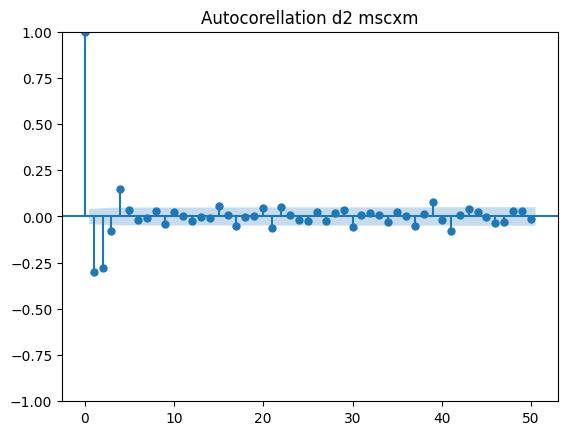

In [29]:
plot_acf(target_mscxm - trends_mscxm[0] - trends_mscxm[1] - trends_mscxm[2], lags=50)
plt.title("Autocorellation d2 mscxm")
plt.show()

**Preparing LSTM**

In [25]:
scaler = MinMaxScaler()

In [31]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE %": mape} 

def plot_training(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'training_plots/{model_name}_training.png')
    plt.close()


**LSTM**

In [29]:
class BaseLSTM(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, return_sequences=True)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True, return_sequences=True)
        self.lstm3 = nn.LSTM(128, 128, batch_first=True)
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [30]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, return_sequences=True)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True, return_sequences=True)
        self.lstm3 = nn.LSTM(128, 128, batch_first=True, return_sequences=True)
        
        self.attention = nn.Sequential(
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 1, bias=False)
        )
        
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)  
        lstm_out, _ = self.lstm3(x)  
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  
        context = (attention_weights * lstm_out).sum(dim=1)  
        x = self.relu(self.fc1(context))  
        x = self.dropout(x)
        return self.fc2(x), attention_weights.squeeze(-1)  

In [ ]:
class DLWR_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_f0 = BaseLSTM(input_size=1)
        self.model_f1 = BaseLSTM(input_size=1)
        self.model_f2 = BaseLSTM(input_size=1)
        

        self.fc = nn.Sequential(
            nn.Linear(3, 64),  #(f0 + f1 + f2)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    
    def forward(self, x_f0, x_f1, x_f2):
        pred_f0 = self.model_f0(x_f0)  
        pred_f1 = self.model_f1(x_f1)  
        pred_f2 = self.model_f2(x_f2)  
        
        # Объединение
        combined = torch.cat([pred_f0, pred_f1, pred_f2], dim=1)  
        return self.fc(combined)  

In [ ]:
class DLWR_Attention_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.lstm_f0 = AttentionLSTM(input_size, hidden_size)
        self.lstm_f1 = AttentionLSTM(input_size, hidden_size)
        self.lstm_f2 = AttentionLSTM(input_size, hidden_size)
        self.fc = nn.Linear(3, 1)  
    
    def forward(self, x_f0, x_f1, x_f2):
        pred_f0, _ = self.lstm_f0(x_f0)
        pred_f1, _ = self.lstm_f1(x_f1)
        pred_f2, _ = self.lstm_f2(x_f2)
        combined = torch.cat([pred_f0, pred_f1, pred_f2], dim=1)
        return self.fc(combined)

In [43]:
import torch
print(torch.cuda.is_available())  # Должно быть True
print(torch.cuda.get_device_name(0))  # Название вашей GPU (например, "RTX 3060")

False


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
#saving graphs
os.makedirs("training_plots", exist_ok=True)

components_imoex = {
    'f0': trends_imoex[0], 
    'f1': trends_imoex[1],
    'f2': trends_imoex[2],
    'd2': noise_imoex
}

scalers = {}
scaled_components = {}
for name, data in components_imoex.items():
    scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    scalers[name] = scaler
    scaled_components[name] = scaled